In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, dopioe


In [2]:
def unit_det(Q, symmetrize=True):
    Q = np.asarray(Q, dtype=float)
    d = np.linalg.det(Q)
    if not np.isfinite(d) or d <= 0: raise ValueError("det(Q) must be positive and finite")
    s = 1/np.sqrt(d)
    return s*Q, s
    

In [3]:
x, y = np.linspace(-100, 100, 100), np.linspace(-100, 100, 100)
X, Y = np.meshgrid(x, y, indexing='ij')

xc, yc = 0, 0
Q11, Q12, Q22 = 1, 0.25, 1
psi0 = -100
Rc = 35
A = - psi0 / Rc**2

# rescale Q to have unit determinant
Q, _ = unit_det(Q=np.array([[Q11, Q12], [Q12, Q22]]))
q11, q12, q22 = Q[0,0], Q[0,1], Q[1,1]

df_res = pd.DataFrame({'xc': [xc], 'yc': [yc], 'q11': [q11], 'q12': [q12], 'q22': [q22],
                        'psi0': [psi0], 'Rc': [Rc], 'A': [A]})

dx, dy = X - xc, Y - yc
# rho2 = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
rho2 = (q11*dx + q12*dy)**2 + (q12*dx + q22*dy)**2
psi = psi0 * np.exp( - rho2 / Rc**2 )
u =   psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q12*dx + 2*q22*dy ) / Rc**2
v = - psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q11*dx + 2*q12*dy ) / Rc**2

vt = -2*A*np.sqrt(rho2)*np.exp(-rho2/Rc**2)

df_res


,xc,yc,q11,q12,q22,psi0,Rc,A
0,0,0,1.032796,0.258199,1.032796,-100,35,0.081633


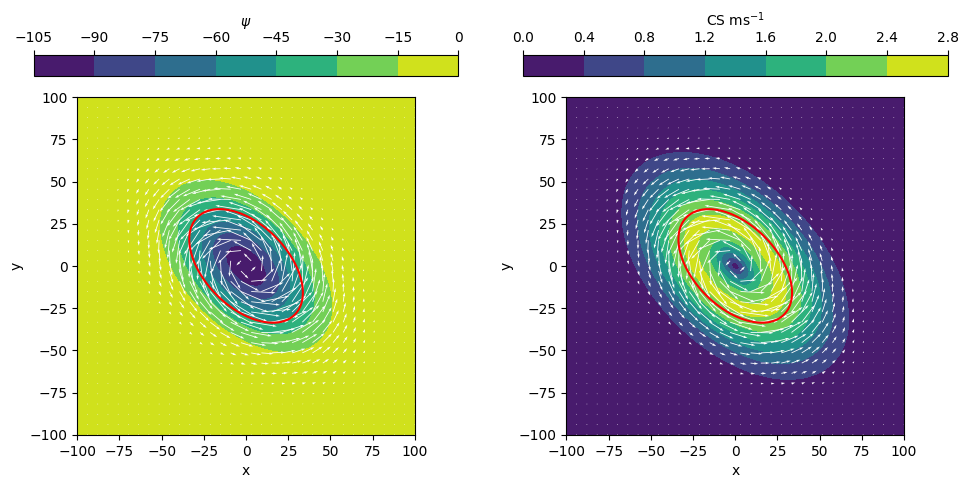

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# First subplot
c0 = axs[0].contourf(X, Y, psi)
fig.colorbar(c0, ax=axs[0], label=r'$\psi$',
             orientation='horizontal', location='top')
spac = 3
axs[0].quiver(X[::spac, ::spac], Y[::spac, ::spac],
              u[::spac, ::spac], v[::spac, ::spac], color='white')
axs[0].contour(X, Y, rho2, colors='r', levels=[1000], alpha=1)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')

# Second subplot
c1 = axs[1].contourf(X, Y, np.hypot(u, v))
fig.colorbar(c1, ax=axs[1], label=r'CS ms$^{-1}$',
             orientation='horizontal', location='top')
axs[1].quiver(X[::spac, ::spac], Y[::spac, ::spac],
              u[::spac, ::spac], v[::spac, ::spac], color='white')
axs[1].contour(X, Y, rho2, colors='r', levels=[1000], alpha=1)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()


In [5]:
x0, y0 = 0, 0
r = 25
# nearest indices to (x0, y0)
i0 = np.argmin(np.abs(x - x0))
j0 = np.argmin(np.abs(y - y0)) 
# zonal transect at y = y0
mask_x = np.abs(x - x0) < r
x1, y1 = x[mask_x], np.full(np.sum(mask_x), y[j0])
u1, v1 = u[mask_x, j0], v[mask_x, j0]
# meridional transect at x = x0
mask_y = np.abs(y - y0) < r
x2, y2 = np.full(np.sum(mask_y), x[i0]), y[mask_y]
u2, v2 = u[i0, mask_y], v[i0, mask_y]

xc_dop, yc_dop, w_dop, AQ_dop, *_ = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
A_dop = np.sqrt(np.linalg.det(AQ_dop)) # det(Q) = 1
q11_dop, q12_dop, q22_dop = AQ_dop[0,0]/A_dop, AQ_dop[1,0]/A_dop, AQ_dop[1,1]/A_dop
Q_dop = np.array([[q11_dop, q12_dop], [q12_dop, q22_dop]])
df_res.loc[len(df_res)] = {'xc': xc_dop, 'yc': yc_dop, 'q11': q11_dop, 'q12': q12_dop, 'q22': q22_dop,
                            'psi0': np.nan, 'Rc': np.nan, 'A': A_dop}
df_res


,xc,yc,q11,q12,q22,psi0,Rc,A
0,0.000000,0.000000,1.032796,0.258199,1.032796,-100.0,35.0,0.081633
1,-0.010563,-0.010563,1.032661,0.257661,1.032661,NaN,NaN,0.079329


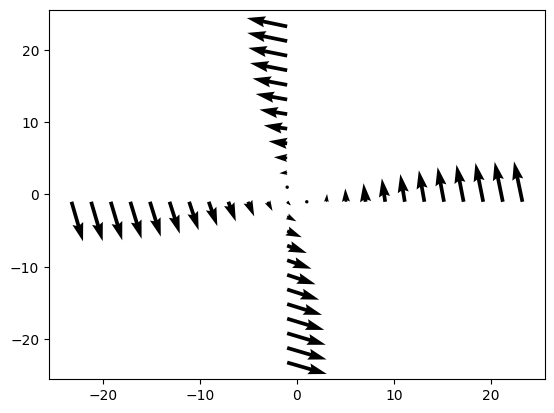

In [6]:
plt.quiver(x1, y1, u1, v1)
plt.quiver(x2, y2, u2, v2)


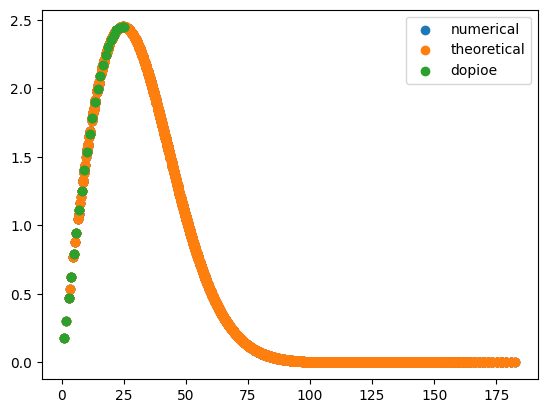

In [7]:
points1 = set(zip(x1, y1)); points2 = set(zip(x2, y2))
common_points = points1 & points2
# Remove duplicates from (x1, y1, u1, v1)
mask = ~np.array([(x, y) in common_points for x, y in zip(x1, y1)])
x1f = x1[mask]; y1f = y1[mask]; u1f = u1[mask]; v1f = v1[mask]
# Concatenate with unaltered second set
xi = np.concatenate([x1f, x2]); yi = np.concatenate([y1f, y2])
ui = np.concatenate([u1f, u2]); vi = np.concatenate([v1f, v2])

dx_dop, dy_dop = xi - xc_dop, yi - yc_dop
rho2_dop = q11_dop*dx_dop**2 + 2*q12_dop*dx_dop*dy_dop + q22_dop*dy_dop**2
# rho_dop = np.sqrt(rho2_dop)

rho_dop = np.sqrt((q11_dop*dx_dop + q12_dop*dy_dop)**2
                  + (q12_dop*dx_dop + q22_dop*dy_dop)**2)

def tangential_velocity(xp, yp, up, vp, xc, yc, Q, det1=False):
    Q = np.asarray(Q, float)
    if Q.shape == (3,):
        q11, q12, q22 = Q
        Q = np.array([[q11, q12], [q12, q22]], float)
    if det1:
        d = np.linalg.det(Q)
        if d != 0:
            Q /= np.sqrt(d)

    xp, yp, up, vp = (np.asarray(a, float) for a in (xp, yp, up, vp))
    r   = np.stack((xp - xc, yp - yc), axis=-1)
    g   = 2.0 * (r @ Q.T)                    # ∇F
    J   = np.array([[0., -1.], [1., 0.]])    # +90° rot
    tau = g @ J.T                             # tangent
    nrm = np.linalg.norm(tau, axis=-1, keepdims=True)
    t_hat = np.divide(tau, nrm, out=np.zeros_like(tau), where=nrm > 0)

    vel = np.stack((up, vp), axis=-1)
    vt  = np.sum(vel * t_hat, axis=-1)
    vt  = np.where(nrm.squeeze() > 0, vt, np.nan)
    return vt#, t_hat
    
vt_dop = np.abs(tangential_velocity(xi, yi, ui, vi, xc_dop, yc_dop, Q_dop))
vt_numerical = tangential_velocity(X.flatten(), Y.flatten(), u.flatten(), v.flatten(), xc, yc, Q)
plt.scatter(np.sqrt(rho2), np.abs(vt_numerical), label='numerical') # Why does this not match the theoretical????

plt.scatter(np.sqrt(rho2), np.abs(vt), label='theoretical')

plt.scatter(rho_dop, np.abs(vt_dop), label='dopioe')

plt.legend()
